# EDA

In [19]:
# install dependencies
# %pip install kagglehub
# %pip install --upgrade ipywidgets

import os
import shutil
from pathlib import Path
import kagglehub

dataset = "abdallahalidev/plantvillage-dataset"
local_dir = Path("plantvillage-dataset")

if not local_dir.exists():
    print("Downloading dataset for the first time…")
    # this returns the path to your kagglehub cache
    cached_path = kagglehub.dataset_download(dataset)
    # copy everything into your own folder
    shutil.copytree(cached_path, local_dir)
    print(f"Copied into {local_dir!r}")
else:
    print(f"Dataset already present in {local_dir!r}, skipping download.")

print("Path to dataset files:", local_dir.resolve())


Dataset already present in PosixPath('plantvillage-dataset'), skipping download.
Path to dataset files: /home/gustavo/EDA_VpC2/plantvillage-dataset


In [20]:
# remove the top-level directory created by kagglehub because it has a space in its name
!mv ./{local_dir}/plantvillage\ dataset/* ./{local_dir}  2>/dev/null || true
!rmdir ./{local_dir}/plantvillage\ dataset  2>/dev/null || true

# change files extension to lowecase
for file in local_dir.rglob("*.*"):
    if file.suffix.lower() != file.suffix:
        new_file = file.with_suffix(file.suffix.lower())
        file.rename(new_file)

Counter({'segmented': 54306, 'grayscale': 54303, 'color': 54303})


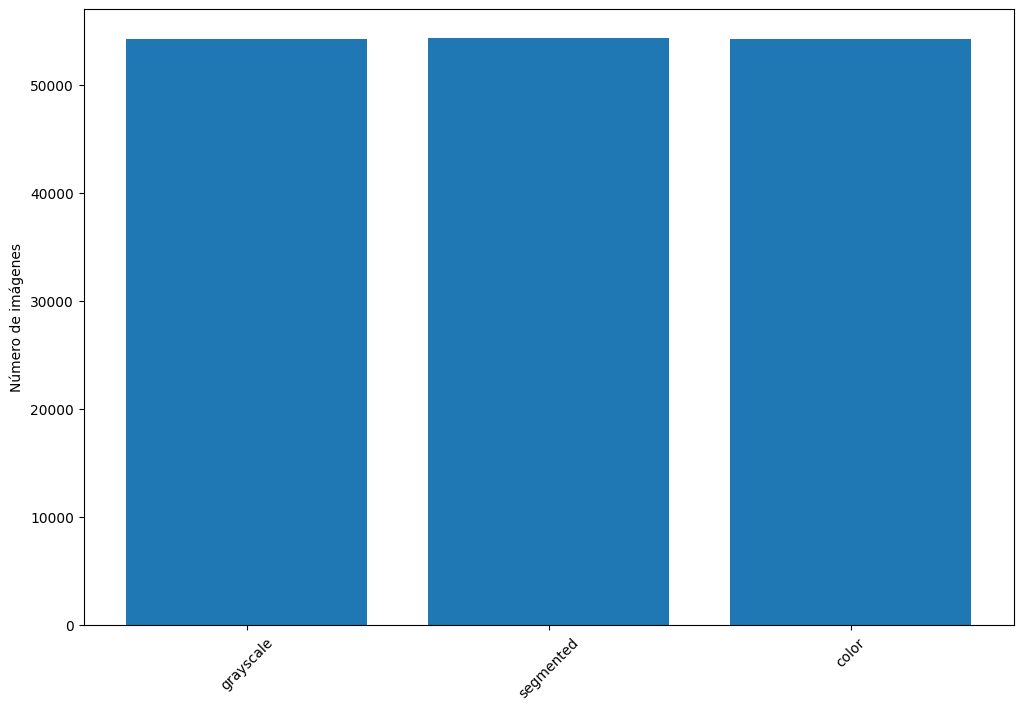

In [21]:
from collections import Counter

counts = Counter()
for cls_dir in local_dir.iterdir():
    if cls_dir.is_dir():
        img_files = [p for p in cls_dir.rglob("*.jpg")]
        n = len(img_files)  # ajusta la extensión si es necesario
        counts[cls_dir.name] = n

# Imprime y grafica
print(counts)
import matplotlib.pyplot as plt

plt.bar(counts.keys(), counts.values())
plt.ylabel("Número de imágenes")
plt.xticks(rotation=45)
plt.show()


**Algunas muestras aleatorias**

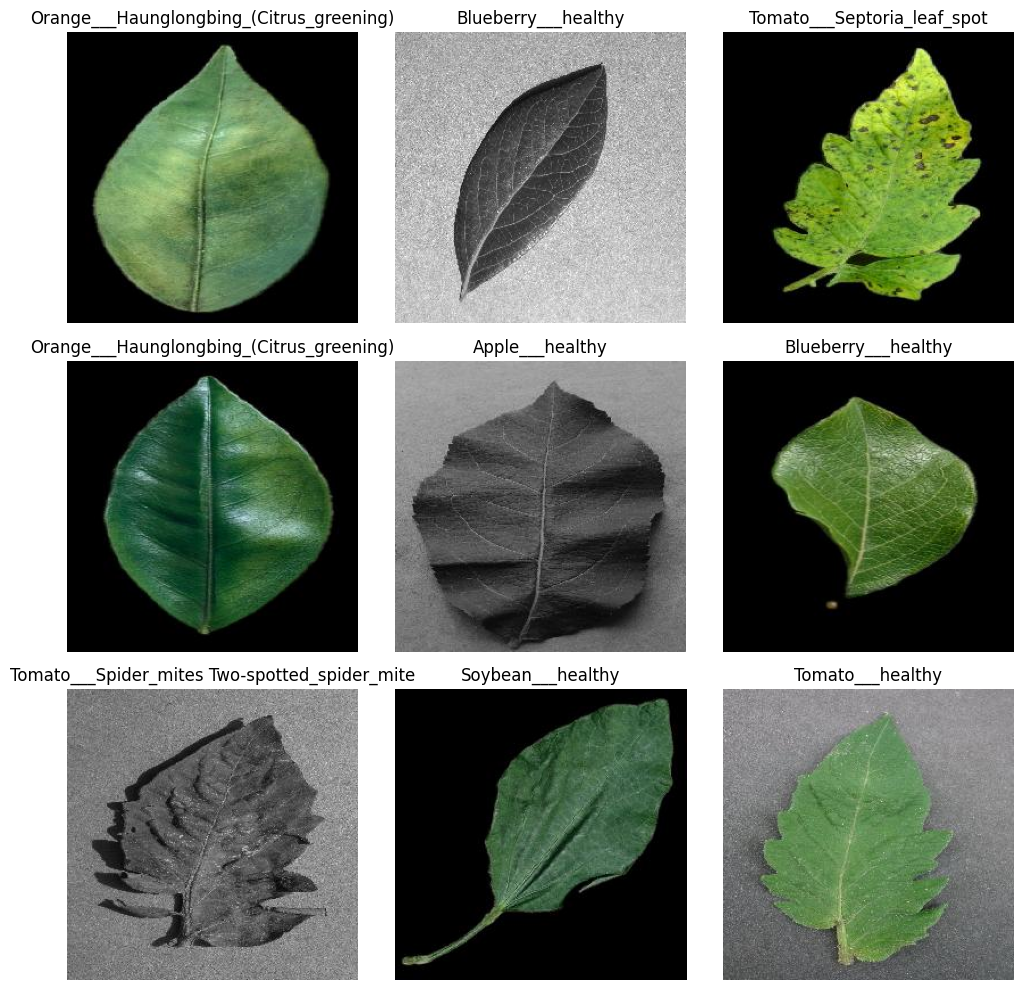

In [22]:
import random
import matplotlib.pyplot as plt
from PIL import Image

def show_random_samples(n=9):
    fig, axes = plt.subplots(int(n**0.5), int(n**0.5), figsize=(10,10))
    axes = axes.flatten()
    all_files = list(local_dir.rglob("*.jpg"))
    samples = random.sample(all_files, n)
    for ax, img_path in zip(axes, samples):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(img_path.parent.name)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

show_random_samples(9)

## Creación de un dataframe para organizar las imágenes

In [23]:
import pandas as pd
from pathlib import Path


base_dir   = local_dir


records = []
for cls_dir in base_dir.iterdir():
    if not cls_dir.is_dir():
        continue
    for subdir in cls_dir.iterdir():
        raw_label = subdir.name         
        parts     = raw_label.split("___")
        plant     = parts[0]                   
        disease   = parts[1] if len(parts)>1 else "healthy"

      
        for img_path in subdir.rglob("*"):
            if img_path.suffix.lower() == ".jpg":
                records.append({
                    "path":       str(img_path),
                    "raw_label":  raw_label,
                    "plant":      plant,
                    "disease":    disease,
                    "is_outlier": False
                })


df = pd.DataFrame(records)

print(df.info())
deseases = df['disease'].unique()
print("Cantidad de enfermedades:", len(deseases))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162912 entries, 0 to 162911
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   path        162912 non-null  object
 1   raw_label   162912 non-null  object
 2   plant       162912 non-null  object
 3   disease     162912 non-null  object
 4   is_outlier  162912 non-null  bool  
dtypes: bool(1), object(4)
memory usage: 5.1+ MB
None
Cantidad de enfermedades: 21


## 1. Análisis de distribución de colores

ANÁLISIS DE DISTRIBUCIÓN DE COLORES
 Dataset: 162912 imágenes totales
 Analizando muestra de: 30 imágenes


Cargando imágenes:   0%|          | 0/30 [00:00<?, ?it/s]

Se cargaron 30 imágenes de 162912 totales

 Analizando distribución RGB...


Analizando RGB:   0%|          | 0/30 [00:00<?, ?it/s]

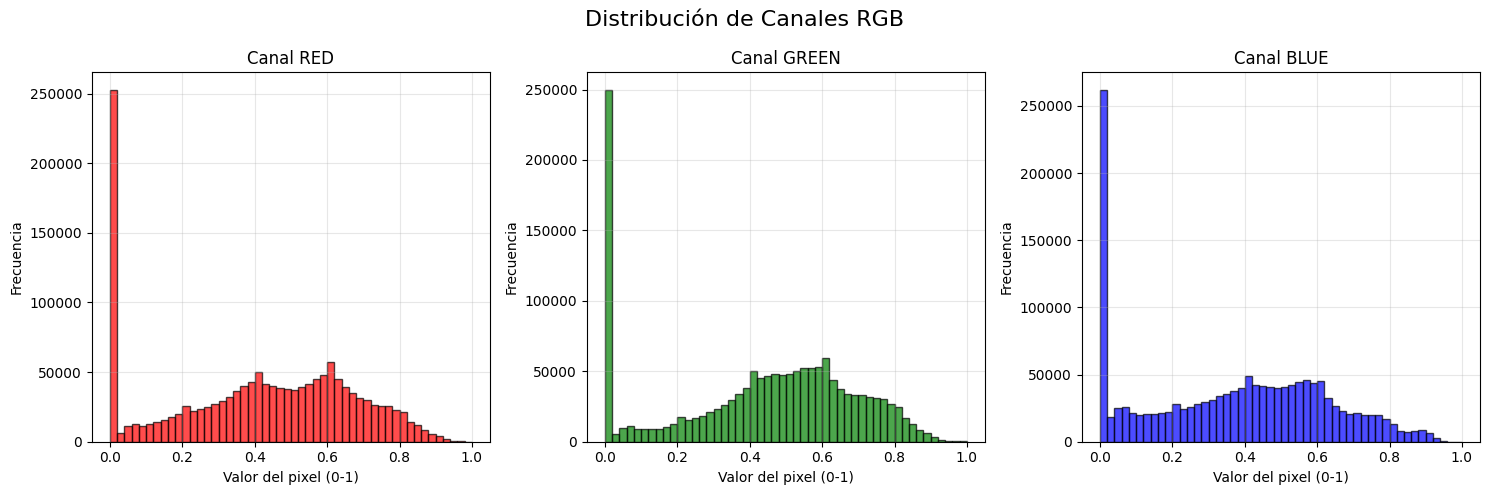


 Analizando distribución HSV...


Analizando HSV:   0%|          | 0/30 [00:00<?, ?it/s]

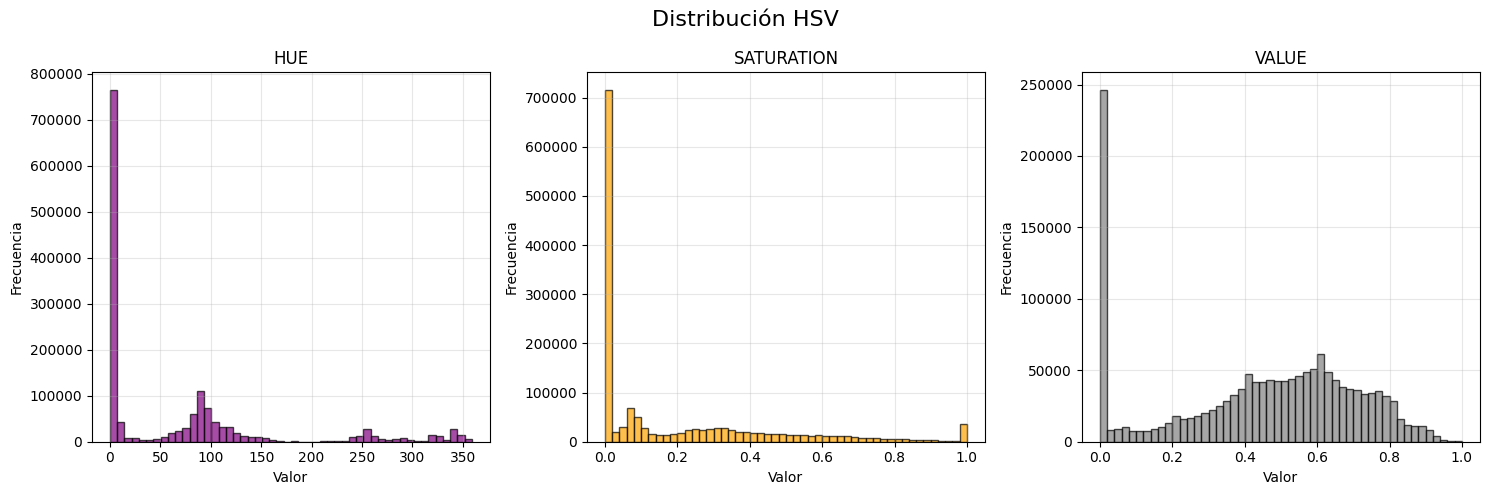


 Analizando distribución de brillo...


Calculando brillo:   0%|          | 0/30 [00:00<?, ?it/s]

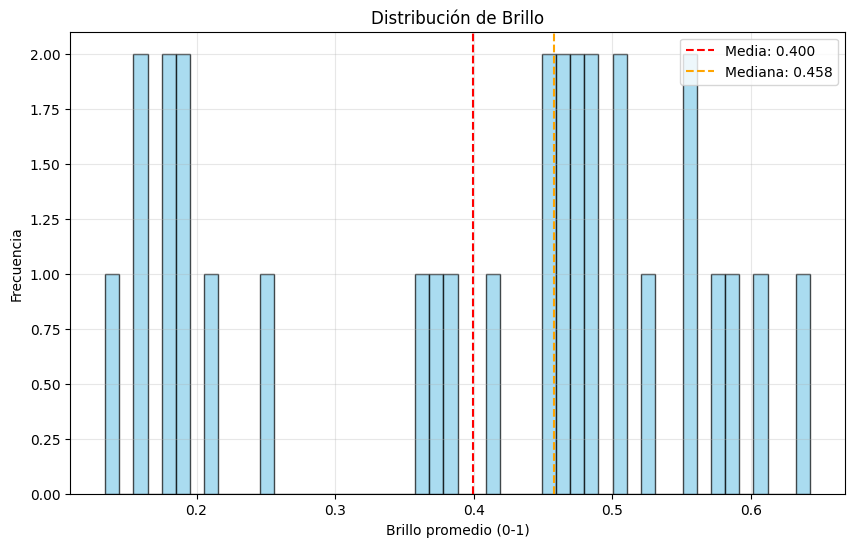


 Extrayendo colores dominantes...


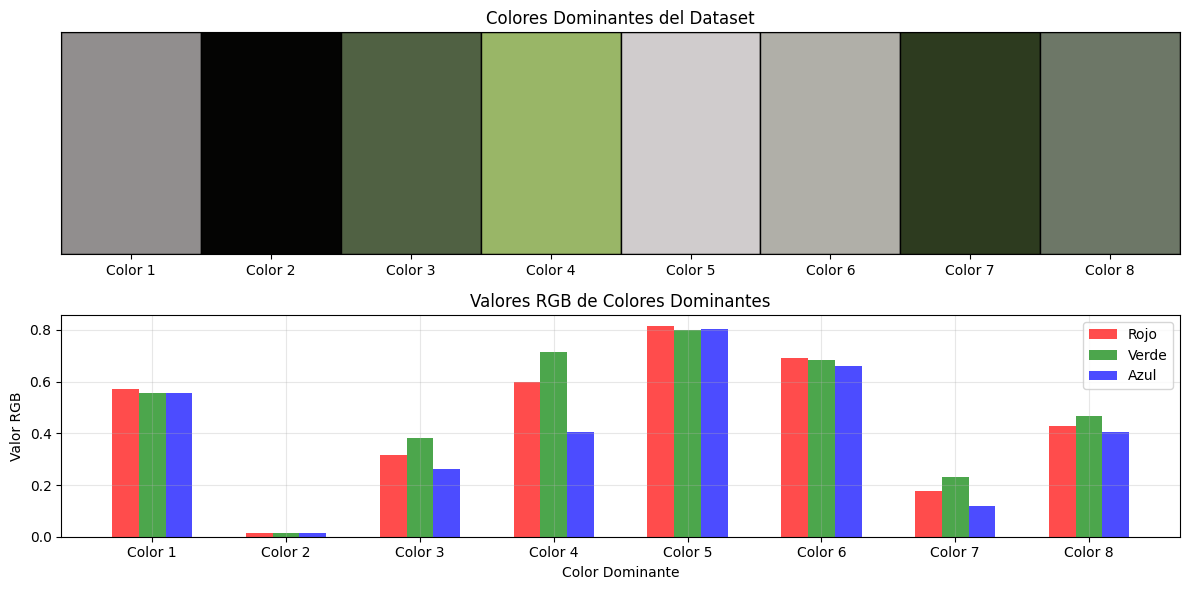

ESTADÍSTICAS DE DISTRIBUCIÓN DE COLORES

Canales RGB:
  RED: Media=0.405, Desv.Est=0.259, Min=0.000, Max=1.000
  GREEN: Media=0.429, Desv.Est=0.259, Min=0.000, Max=1.000
  BLUE: Media=0.365, Desv.Est=0.256, Min=0.000, Max=1.000

Canal dominante: GREEN

HSV:
  Matiz: Media=66.784
  Saturación: Media=0.192
  Valor: Media=0.441

Brillo:
  Media: 0.400
  Desviación: 0.156

Análisis de sesgos:
-> El Dataset tiene una distribución de brillo balanceada
-> El Dataset tiene colores DESATURADOS


In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import cv2
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm
import random

# Configurar matplotlib
plt.rcParams['figure.figsize'] = (12, 8)

def load_sample_images(df, n_samples=200):
    sample_df = df.sample(n=min(n_samples, len(df)), random_state=42)
    
    images = []
    for _, row in tqdm(sample_df.iterrows(), total=len(sample_df), desc="Cargando imágenes"):
        try:
            img = Image.open(row['path']).convert('RGB')
            img = img.resize((224, 224))  # Redimensionar para consistencia
            img_array = np.array(img) / 255.0  # Normalizar a [0, 1]
            images.append(img_array)
        except Exception as e:
            print(f"Error cargando {row['path']}: {e}")
            continue
    
    print(f"Se cargaron {len(images)} imágenes de {len(df)} totales")
    return images

def analyze_rgb_distribution(images):
    rgb_values = {'red': [], 'green': [], 'blue': []}
    
    for img in tqdm(images, desc="Analizando RGB"):
        rgb_values['red'].extend(img[:, :, 0].flatten())
        rgb_values['green'].extend(img[:, :, 1].flatten())
        rgb_values['blue'].extend(img[:, :, 2].flatten())
    
    return rgb_values

def analyze_hsv_distribution(images):
    hsv_values = {'hue': [], 'saturation': [], 'value': []}
    
    for img in tqdm(images, desc="Analizando HSV"):
        img_hsv = cv2.cvtColor(img.astype(np.float32), cv2.COLOR_RGB2HSV)
        hsv_values['hue'].extend(img_hsv[:, :, 0].flatten())
        hsv_values['saturation'].extend(img_hsv[:, :, 1].flatten())
        hsv_values['value'].extend(img_hsv[:, :, 2].flatten())
    
    return hsv_values

def calculate_brightness(images):
    brightness = []
    for img in tqdm(images, desc="Calculando brillo"):
        brightness.append(np.mean(img))
    return brightness

def extract_dominant_colors(images, k=8):
    sample_images = random.sample(images, min(20, len(images)))
    
    all_pixels = []
    for img in sample_images:
        pixels = img[::4, ::4, :].reshape(-1, 3)
        all_pixels.extend(pixels)
    
    # K-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(all_pixels)
    
    return kmeans.cluster_centers_

def plot_rgb_histograms(rgb_values):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    colors = ['red', 'green', 'blue']
    
    for i, color in enumerate(colors):
        axes[i].hist(rgb_values[color], bins=50, color=color, alpha=0.7, edgecolor='black')
        axes[i].set_title(f'Canal {color.upper()}')
        axes[i].set_xlabel('Valor del pixel (0-1)')
        axes[i].set_ylabel('Frecuencia')
        axes[i].grid(True, alpha=0.3)
    
    plt.suptitle('Distribución de Canales RGB', fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_hsv_histograms(hsv_values):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    channels = ['hue', 'saturation', 'value']
    colors = ['purple', 'orange', 'gray']
    
    for i, (channel, color) in enumerate(zip(channels, colors)):
        axes[i].hist(hsv_values[channel], bins=50, color=color, alpha=0.7, edgecolor='black')
        axes[i].set_title(f'{channel.upper()}')
        axes[i].set_xlabel('Valor')
        axes[i].set_ylabel('Frecuencia')
        axes[i].grid(True, alpha=0.3)
    
    plt.suptitle('Distribución HSV', fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_brightness_histogram(brightness):
    plt.figure(figsize=(10, 6))
    plt.hist(brightness, bins=50, color='skyblue', alpha=0.7, edgecolor='black')
    plt.axvline(np.mean(brightness), color='red', linestyle='--', 
                label=f'Media: {np.mean(brightness):.3f}')
    plt.axvline(np.median(brightness), color='orange', linestyle='--', 
                label=f'Mediana: {np.median(brightness):.3f}')
    plt.title('Distribución de Brillo')
    plt.xlabel('Brillo promedio (0-1)')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_dominant_colors(colors):
    """Visualiza paleta de colores dominantes"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
    
    # Paleta visual
    for i, color in enumerate(colors):
        ax1.add_patch(plt.Rectangle((i, 0), 1, 1, facecolor=color, edgecolor='black'))
    
    ax1.set_xlim(0, len(colors))
    ax1.set_ylim(0, 1)
    ax1.set_title('Colores Dominantes del Dataset')
    ax1.set_xticks(np.arange(len(colors)) + 0.5)
    ax1.set_xticklabels([f'Color {i+1}' for i in range(len(colors))])
    ax1.set_yticks([])
    
    # Gráfico de barras RGB
    x = np.arange(len(colors))
    ax2.bar(x - 0.2, colors[:, 0], 0.2, label='Rojo', color='red', alpha=0.7)
    ax2.bar(x, colors[:, 1], 0.2, label='Verde', color='green', alpha=0.7)
    ax2.bar(x + 0.2, colors[:, 2], 0.2, label='Azul', color='blue', alpha=0.7)
    
    ax2.set_xlabel('Color Dominante')
    ax2.set_ylabel('Valor RGB')
    ax2.set_title('Valores RGB de Colores Dominantes')
    ax2.set_xticks(x)
    ax2.set_xticklabels([f'Color {i+1}' for i in range(len(colors))])
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def print_color_statistics(rgb_values, hsv_values, brightness):
    print("=" * 50)
    print("ESTADÍSTICAS DE DISTRIBUCIÓN DE COLORES")
    print("=" * 50)
    
    print("\nCanales RGB:")
    for channel in ['red', 'green', 'blue']:
        values = rgb_values[channel]
        print(f"  {channel.upper()}: Media={np.mean(values):.3f}, "
              f"Desv.Est={np.std(values):.3f}, Min={np.min(values):.3f}, Max={np.max(values):.3f}")
    
    rgb_means = [np.mean(rgb_values[ch]) for ch in ['red', 'green', 'blue']]
    dominant_channel = ['red', 'green', 'blue'][np.argmax(rgb_means)]
    print(f"\nCanal dominante: {dominant_channel.upper()}")
    
    print(f"\nHSV:")
    print(f"  Matiz: Media={np.mean(hsv_values['hue']):.3f}")
    print(f"  Saturación: Media={np.mean(hsv_values['saturation']):.3f}")
    print(f"  Valor: Media={np.mean(hsv_values['value']):.3f}")
    
    print(f"\nBrillo:")
    print(f"  Media: {np.mean(brightness):.3f}")
    print(f"  Desviación: {np.std(brightness):.3f}")
    
    print(f"\nAnálisis de sesgos:")
    if np.mean(brightness) < 0.3:
        print("-> El Dataset tiende hacia imágenes OSCURAS")
    elif np.mean(brightness) > 0.7:
        print("-> El Dataset tiende hacia imágenes CLARAS")
    else:
        print("-> El Dataset tiene una distribución de brillo balanceada")
    
    if np.mean(hsv_values['saturation']) < 0.3:
        print("-> El Dataset tiene colores DESATURADOS")
    elif np.mean(hsv_values['saturation']) > 0.7:
        print("-> El Dataset tiene colores MUY SATURADOS")
    else:
        print("-> El Dataset tiene saturación balanceada")

def analyze_color_distribution(df, n_samples=300):
    print("ANÁLISIS DE DISTRIBUCIÓN DE COLORES")
    print("=" * 40)
    print(f" Dataset: {len(df)} imágenes totales")
    print(f" Analizando muestra de: {min(n_samples, len(df))} imágenes")
    
    images = load_sample_images(df, n_samples)
    
    if len(images) == 0:
        print(" No se pudieron cargar imágenes")
        return
    
    print("\n Analizando distribución RGB...")
    rgb_values = analyze_rgb_distribution(images)
    plot_rgb_histograms(rgb_values)
    

    print("\n Analizando distribución HSV...")
    hsv_values = analyze_hsv_distribution(images)
    plot_hsv_histograms(hsv_values)
    
    print("\n Analizando distribución de brillo...")
    brightness = calculate_brightness(images)
    plot_brightness_histogram(brightness)
    
    print("\n Extrayendo colores dominantes...")
    dominant_colors = extract_dominant_colors(images)
    plot_dominant_colors(dominant_colors)
    
    print_color_statistics(rgb_values, hsv_values, brightness)
    


analyze_color_distribution(df, n_samples=30)

## 2. Análisis de *bounding boxes*
En este caso, las imágenes no traen bounding boxes asociados

## 3. Análisis de distribución de etiquetas

Para esto, se puede trabajar con las cantidades de imágenes por conjunto de plantas vs. enfermedades

## 4. Dimensión de imágenes y de radios de aspecto

Anchos:  256 (min), 256.0 (mediana), 470 (max)
Altos:   256 (min), 256.0 (mediana), 512 (max)


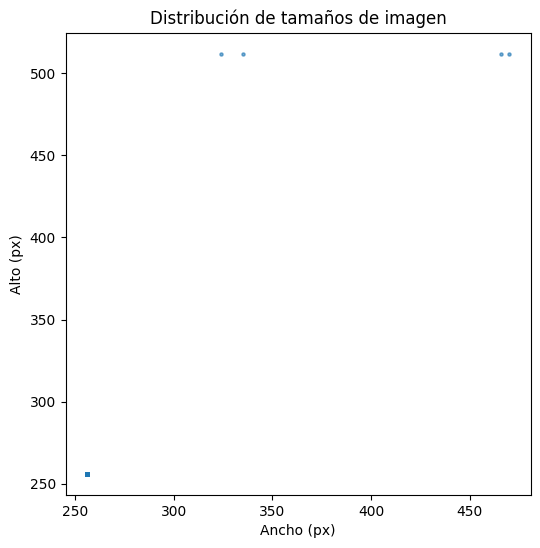

Aspect ratio: min= 0.6328125 mediana= 1.0 max= 1.0


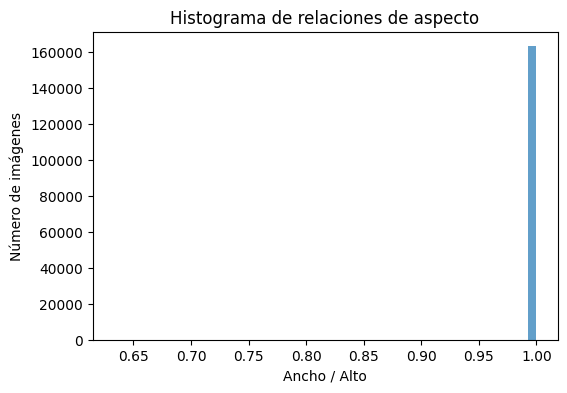

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

sample_paths = df["path"] # se analizan todas las imágenes originales
widths, heights = [], []
for p in sample_paths:
    img = Image.open(p)
    w, h = img.size
    widths.append(w)
    heights.append(h)


print("Anchos: ", np.min(widths), "(min),", np.median(widths), "(mediana),", np.max(widths), "(max)")
print("Altos:  ", np.min(heights), "(min),", np.median(heights), "(mediana),", np.max(heights), "(max)")

# Scatter de width vs height
plt.figure(figsize=(6,6))
plt.scatter(widths, heights, s=5, alpha=0.6)
plt.xlabel("Ancho (px)")
plt.ylabel("Alto (px)")
plt.title("Distribución de tamaños de imagen")
plt.show()

# Relación de aspecto
aspects = np.array(widths) / np.array(heights)
print("Aspect ratio: min=", np.min(aspects), "mediana=", np.median(aspects), "max=", np.max(aspects))

# Histograma de relaciones de aspecto
plt.figure(figsize=(6,4))
plt.hist(aspects, bins=50, alpha=0.7)
plt.xlabel("Ancho / Alto")
plt.ylabel("Número de imágenes")
plt.title("Histograma de relaciones de aspecto")
plt.show()


No se observan grandes variaciones en el radio de apecto, pero algunas imágenes son mayores que el estándar de 256x256

In [26]:
# Mostrar imágenes con valores superiores a la mediana
median_width = np.median(widths)
median_height = np.median(heights)
large_images = [sample_paths[i] for i in range(len(sample_paths)) 
               if widths[i] > median_width and heights[i] > median_height]

print(f"\nImágenes con ancho > {median_width:.0f} px y alto > {median_height:.0f} px:")
for img_path in large_images:
   print(img_path)


Imágenes con ancho > 256 px y alto > 256 px:
plantvillage-dataset/segmented/Peach___Bacterial_spot/Rut._Bact.S 3430_final_masked.jpg
plantvillage-dataset/segmented/Peach___Bacterial_spot/Rutg._Bact.S 1526_final_masked.jpg
plantvillage-dataset/segmented/Tomato___Spider_mites Two-spotted_spider_mite/Com.G_SpM_FL 1378_final_masked.jpg
plantvillage-dataset/segmented/Strawberry___Leaf_scorch/RS_L.Scorch 1161_final_masked.jpg


cómo las imágenes son pocas se las puede corregir o eliminar

## 5. Calidad de imágenes

## Exportar para continuar con el pipeline del procesamiento de imágenes en otra notebook

In [31]:
df_clean.to_csv("dataset_clean.csv", index=False)


## transfer to csv for the next notebooks
# df_clean = pd.read_csv("dataset_clean.csv")